In [ ]:
#default_exp core.models

In [ ]:
#export
import torch
from torch import nn
from torch.nn import functional as F

from vase.config import DATA_PATH

In [ ]:
#hide
from vase.core.datasets.moving_mnist import MovingMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Models
> Pytorch Models used for encoders, decoders, and classifiers. See Section A.1 of [Aachille et al.](https://arxiv.org/pdf/1808.06508.pdf) for details

In [ ]:
#hide 
from vase.core.datasets.moving_mnist import MovingMNIST

In [ ]:
#hide
batch_size = 128
latents = 5
max_environments = 24
mm = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
loader = DataLoader(mm, batch_size)

1.1%

100.0%


Extracting /home/oliverdaniels-koch/vase/vase/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/oliverdaniels-koch/vase/vase/data/MNIST/raw


102.8%


Extracting /home/oliverdaniels-koch/vase/vase/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/oliverdaniels-koch/vase/vase/data/MNIST/raw




100.0%


Extracting /home/oliverdaniels-koch/vase/vase/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/oliverdaniels-koch/vase/vase/data/MNIST/raw



112.7%

Extracting /home/oliverdaniels-koch/vase/vase/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/oliverdaniels-koch/vase/vase/data/MNIST/raw



## Encoder


In [ ]:
#export
class Encoder(nn.Module):
    def __init__(self, latents=10):
        super().__init__()
        self.latents = latents
        #NOTE: no pooling? should compare results with and without
        self.conv1 = nn.Conv2d(1, 64, (4,4), stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, (4,4), 2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, (4,4), 2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, (4,4), 2, padding=1)
        self.linear = nn.Linear(2048, 256)
        self.linear_mu = nn.Linear(256, self.latents)
        self.linear_sigma = nn.Linear(256, self.latents)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Returns mean and standard deviation to parameterize sigmoid, 
        and final layer to compute environment
        """
        x = self.relu(self.conv1(x)) # (batch_size, 64, 32, 32)
        x = self.relu(self.conv2(x)) # (batch_size, 64, 16, 16)
        x = self.relu(self.conv3(x)) # (batch_size, 128, 8, 8)
        x = self.relu(self.conv4(x)) # (batch_size, 128, 4, 4)
        x = x.reshape(-1, 2048)
        final = self.relu(self.linear(x))
        mu = self.linear_mu(final)
        sigma = torch.exp(self.linear_sigma(final))
        return mu, sigma, final.detach() #detach to prevent gradient flow

In [ ]:
batch_size = 128
latents = 5

In [ ]:
mm = MovingMNIST(DATA_PATH, transform=ToTensor())
loader = DataLoader(mm, batch_size)
batch, _, _= iter(loader).next()

In [ ]:
encoder = Encoder(latents=latents)

In [ ]:
mu, sigma, final = encoder(batch)

In [ ]:
assert mu.shape == torch.Size((batch_size, latents))
assert sigma.shape == torch.Size((batch_size, latents))

## Environmental Inference Network
NOTE: not sure if this receives the $\mu$'s or the layer before the $\mu's$ - I think the layer before?

Section A.1: "We attach an additional fully connected layer to the last layer of the encoder (gradients to the encoder are stopped)."

In [ ]:
#export
class EnvironmentInference(nn.Module):
    def __init__(self, max_environmnets: int, input_dim=256):
        super().__init__()
        self.max_environments = max_environmnets
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, max_environmnets)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, final_latent):
        x = self.linear(final_latent)
        return self.softmax(x)

In [ ]:
env_inf = EnvironmentInference(max_environmnets=max_environments)
env_dist = env_inf(final)

In [ ]:
assert env_dist.shape == torch.Size([batch_size, max_environments])

In [ ]:
env_dist.sum(dim=1).shape

torch.Size([128])

In [ ]:
assert torch.all(torch.isclose(env_dist.sum(dim=1), torch.ones(128)))

### Environmental  Encoding

See "Environment index" in section A.2 - softmax is averaged across data in batch, then argmax is taken

In [ ]:
avg_env_dist = env_dist.mean(dim=0)

In [ ]:
assert avg_env_dist.shape == torch.Size((24,))

In [ ]:
env_idx = torch.argmax(avg_env_dist)
env_idx

tensor(2)

In [ ]:
F.one_hot(env_idx, num_classes=max_environments)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#export
def env_dist_to_one_hot(env_dist: torch.Tensor, max_environments: int) -> torch.Tensor:
    """Converts a batch of distributions to a one-hot vector"""
    avg_env_dist = env_dist.mean(dim=0)
    env_idx = torch.argmax(avg_env_dist)
    return F.one_hot(env_idx, num_classes=max_environments)


In [ ]:
batch, _, _= iter(loader).next()
_, _, final = encoder(batch)
env_dist = env_inf(final)
one_hot_env_idx = env_dist_to_one_hot(env_dist, max_environments=max_environments)

In [ ]:
assert one_hot_env_idx.shape == torch.Size([max_environments])
assert one_hot_env_idx.max() == 1
assert one_hot_env_idx.sum() == 1

## Decoder

In [ ]:
broad_env_idx = one_hot_env_idx.expand((batch_size, -1))
broad_env_idx.shape

torch.Size([128, 24])

In [ ]:
assert torch.equal(broad_env_idx[0], broad_env_idx[1])

In [ ]:
latent_and_env = torch.cat((mu, broad_env_idx), dim=1)

In [ ]:
assert latent_and_env.shape == torch.Size([batch_size, latents + max_environments])

In [ ]:
#export
class Decoder(nn.Module):
    def __init__(self, max_envs=0, latents=10):
        super().__init__()
        self.max_envs = max_envs
        self.latents = latents
        self.linear2 = nn.Linear(latents + max_envs, 256)
        self.linear1 = nn.Linear(256, 2048)
        self.conv4 = nn.ConvTranspose2d(128, 128, (4,4), 2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, (4,4), 2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 64, (4,4), 2, padding=1)
        self.conv1 = nn.ConvTranspose2d(64, 1, (4,4), 2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z, s=None):
        """
        Decode the latent and environmental variables

        Args: 
            z (Tensor): latent variables
            s (Tesnor): one-hot encoded environmental variable (not sure how this works...)
        
        Returns:
            Means for (batchsize, widgt, height) Bernoulli's (which can be interpreted as the reconstructed image)
        """
        batch_size = z.shape[0]
        if s is not None:
            s = s.expand(batch_size, -1)
            z = torch.cat((z, s), dim=1)
        x = self.relu(self.linear2(z)) # (batch_size, 256)
        x = self.relu(self.linear1(x)) # (batch_size, 512)
        x = x.reshape(-1, 128, 4, 4) # (batch_size, 128, 2, 2)
        x = self.relu(self.conv4(x)) # (batch_size, 128, 6, 6)
        x = self.relu(self.conv3(x)) # (batch_size, 64, 14, 14)
        x = self.relu(self.conv2(x)) # (batch_size, 64, 30, 30) WRONG (should be 31)
        out = self.sigmoid(self.conv1(x))
        return out

In [ ]:
batch.shape

torch.Size([128, 1, 64, 64])

In [ ]:
mu, sigma, final = encoder(batch)
env_dist = env_inf(final)
env_idx = env_dist_to_one_hot(env_dist, max_environments=max_environments)
z = mu
s = env_idx

In [ ]:
decoder = Decoder(max_environments, latents)

In [ ]:
z.shape

torch.Size([128, 5])

In [ ]:
rec_img = decoder(z, s)

In [ ]:
rec_img.shape

torch.Size([128, 1, 64, 64])

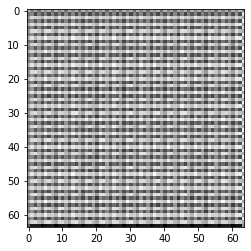

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze(), cmap='gray')

In [ ]:
decoder = Decoder(max_envs=0, latents=latents)

In [ ]:
rec_img = decoder(z, None)

In [ ]:
assert rec_img.shape == torch.Size([batch_size, 1, 64, 64])

## VAEs

### Reparameterization Trick

TODO: explain why you have to do this to compute gradients

In [ ]:
#export
def reparam(mu, logvar):
    eps = torch.randn(logvar.shape)
    std = (0.5 * logvar).exp()
    return mu + std * eps

### Vanilla VAE

In [ ]:
#export
class VanillaVAE(nn.Module):
    def __init__(self,latents=10):
        super().__init__()
        self.encoder = Encoder(latents=latents)
        self.decoder = Decoder(latents=latents)
    
    def forward(self, x):
        mu, logvar, _final = self.encoder(x)
        if self.training:
            z = reparam(mu, logvar)
        else:
            z = mu
        rec_img = self.decoder(z=z)
        return rec_img, mu, logvar

In [ ]:
latents=20
vvae = VanillaVAE(latents=latents)

In [ ]:
rec_img, mu, logvar = vvae(batch)

In [ ]:
assert rec_img.shape == batch.shape

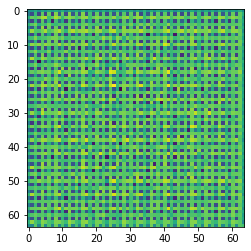

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze())

In [ ]:
assert mu.shape == torch.Size([batch_size, latents])
assert logvar.shape == torch.Size([batch_size, latents])

In [ ]:
vvae.eval()


VanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=20, bias=True)
    (linear_sigma): Linear(in_features=256, out_features=20, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=20, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding

In [ ]:
assert not vvae.training

In [ ]:
rec_img, mu, logvar = vvae(batch)

In [ ]:
rec_img_decode = vvae.decoder(mu)

In [ ]:
assert torch.equal(rec_img, rec_img_decode)

## Classifiers and Regressors